# Modelling Multivariate Data ( The problem of Car sales forecasting)

This code shows how to forecast one variable that depends on other variables or factors. This is a typical situation one faces when trying to forecast multivariate time series or multivariate data in general. The dataset contains numerical and categorical data similar to the ones used in Kaggle competitions. The particular dataset used here contains characteristics of cars, like brand, engine size, model, price, year etc. and predicts future car prices. There are many models one can use to model to forecast in this case, I have chosen two traditional machine learning models SVM and XGBoost to forecast car prices as a function of factors in the database. An analysis of the input data is presented as well a classification of the importance of the factors to the price prediction.

In [1]:
## Libraties
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
from itertools import groupby
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.svm import SVR
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from datetime import datetime, date

### Loading the data.


In [2]:
# Load the data
df = pd.read_csv('Cars_clean.csv')

At this level one needs to analyze the input data to clean and find anomalies, outliers, missing data. In this code that work has been done previously, the current data is already clean.

In [3]:
# Get the number of rows and columns
rows = len(df.axes[0])
cols = len(df.axes[1])
# Print the number of rows and columns
print("Number of Rows: " + str(rows))
print("Number of Columns: " + str(cols))

Number of Rows: 1037
Number of Columns: 19


In [234]:
# To order the data base according to the updated date.
#df_copy = df
#df_copy['date'] = pd.to_datetime(df_copy['lastupdated'])
#df_copy.sort_values(by='date')

###  Defining new variables with better meaning for prediction
Using the data of ceratin variables such as 'lastUpdated', 'registrationexpiry','lastserviced' we define new variables 'DaysUpdated2Now', 'RegistrationDaysRemaining', 'DaysFromLastServiced' by comaring with the present time. Also since FabricationYear is an important data, we transform that information to Car_age but considering the difference between 
today and the fabrication year.

In [4]:
# Some functions to deal with the definition of these new variables.

def DateType1_2_Number(DF, columnName):
    columnNameN = []
    rows = len(DF.axes[0])
    for i in range(rows):
        Y = DF[columnName][i][0:4]
        M = DF[columnName][i][5:7]
        D = DF[columnName][i][8:10]
        a = date(int(Y),int(M),int(D))
        #columnNameN.append( a.timestamp() )
        dt = date(2021,8,12)-a
        columnNameN.append(dt.days)
    return(columnNameN)
def DateType2_2_Number(DF, columnName):
    columnNameN2 = []
    rows = len(DF.axes[0])
    for i in range(rows):
        M = DF[columnName][i][0:2]
        Y = DF[columnName][i][4:9]
        D = 1
        a = date(int(Y),int(M),int(D))
        #columnNameN2.append( a.timestamp() )
        dt = a - date(2021,8,12)
        columnNameN2.append(dt.days)
    return(columnNameN2)

def DateType3_2_Number(DF, columnName):
    columnNameN3 = []
    rows = len(DF.axes[0])
    for i in range(rows):
        M = DF[columnName][i][0:2]
        Y = DF[columnName][i][4:9]
        D = 1
        a = date(int(Y),int(M),int(D))
        #columnNameN2.append( a.timestamp() )
        dt = date(2021,8,12)-a
        columnNameN3.append(dt.days)
    return(columnNameN3)

DaysUpdated2Now = DateType1_2_Number(df, 'lastupdated')
RegistrationDaysRemaining = DateType2_2_Number(df, 'registrationexpiry')
DaysFromLastServiced = DateType3_2_Number(df, 'lastserviced')

## Defining the new variables to related to the dates
df['DaysSinceUpdated2Now'] = DaysUpdated2Now
df['RegistrationDaysRemaining'] = RegistrationDaysRemaining
df['DaysFromLastServiced'] = DaysFromLastServiced

## The car age variable
df['Car_Age'] = 2021-df['FabricationYear']

### Dealing with numerical and categorical data
If data is numerical I scale it approprately, if the data is categorical I introduce dummy variables. I will start with a selection of features of the data.

In [5]:
# Numeric and categorical features:
#numerical_cols = ['enginesize','usd_price','km_mileage','Car_Age','RegistrationDaysRemaining','DaysUpdated2Now','DaysFromLastServiced']      
#numerical_cols = ['enginesize','usd_price','km_mileage','Car_Age','DaysUpdated2Now','DaysFromLastServiced']      
numerical_cols = ['enginesize','usd_price','km_mileage','Car_Age']      

#cat_cols = ['exactmodel','cartype','transmission','seats','previousowners','bodyinteriorcolour','brand','model']    
#cat_cols = ['exactmodel','cartype','transmission','seats','brand','model']    
cat_cols = ['cartype','transmission','seats','brand','model']    
X_num = df[numerical_cols]
X_cat = df[cat_cols]

## Scale numeric data by StandardScaler:
scaler = StandardScaler()  # get a scaler
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns.values) 
X =  X_num_scaled.drop(labels=['usd_price'], axis=1)

## Making dummy features for each categorical column:
list_of_dummies = []
for col in cat_cols:
    dum_col = pd.get_dummies(X_cat[col], prefix=col)
    list_of_dummies.append(dum_col)
X_cat = pd.concat(list_of_dummies, axis=1)   

## Merging numeric and dummy features:
DataNames =numerical_cols+cat_cols

In [6]:
X_cat.head()

,cartype_Convertible,cartype_Coupe,cartype_Hatchback,cartype_Hybrid/Electric,cartype_Luxury,cartype_Motorcycle,cartype_SUV/Crossover,cartype_Sedan,cartype_Truck,cartype_Van/Minivan,...,model_Volkswagen Scirocco R,model_Volkswagen Sharan,model_Volkswagen Tiguan,model_Volkswagen Touareg,model_Volkswagen Touran,model_Volvo S60,model_Volvo V40,model_Volvo V60,model_Volvo XC60,model_Volvo XC90
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
##  Not used now but good to have it for the future.
#### To revert the dummies encoding
#xx = X_cat.stack()
#all =pd.Series(pd.Categorical(xx[xx!=0].index.get_level_values(1))).unique()
#all

## Modeling
In this case I decided to use two models one for assesing the feature importance of the car characteristics relevant for its price and to be able to forecast car prices. I have set up the problem of forecasting car prices first by using the set of prices and charactristics in the database to regress the price against its characteristics, once trainined these models will allow me to forecast car prices and also know which are the most relevant features for the car prices. Car prices and best features will lead us to find a methodology for ranking each car by comparison.

In [7]:
############             PREDICTION
## Separating the relevant variables for prediction
X_1 = pd.concat([X, X_cat], axis=1)
y_1 = X_num_scaled['usd_price']

# dividing X, y into train and test data  test_size=0.25
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state = 0)
##

In [8]:
# dividing X, y into train and test data  test_size=0.25
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state = 0)
# Get the number of rows and columns of the training data
rows = len(X_1_train.axes[0])
cols = len(X_1_train.axes[1])
rows_test = len(X_1_test.axes[0])
cols_test = len(X_1_test.axes[1])
# Print the number of rows and columns
print("Number of Rows for training data: " + str(rows))
print("Number of Columns for training data: " + str(cols))
print("Number of Rows for test data: " + str(rows_test))
print("Number of Columns for test data: " + str(cols_test))

Number of Rows for training data: 777
Number of Columns for training data: 247
Number of Rows for test data: 260
Number of Columns for test data: 247


In [21]:
y_1_train

408   -0.521710
619    0.037026
295   -0.820780
236   -0.866251
453   -0.400649
         ...   
277   -0.866251
763    0.577193
835    1.014869
559   -0.121245
684    0.269863
Name: usd_price, Length: 777, dtype: float64

### SVM regression

In this case I use Support Vector Machines for regression, focusing more in trying to forecast the car prices. The numerical data is scaled and combined with the categorical data. The kernel I use is the radial basis function.

'\npylab.legend()\n# legend below figure\npylab.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)\nIn_score_train = svr_rbf.score(X_1_train, y_1_train)\nprint(In_score_train)\nplt.text(0.5,-60.6, r\'Score = 0.857\' , fontsize=10)\n#Plotting Test set regression\naxis_x_test = np.arange(1,subSet_length*.25+1)\nplt.figure()\nplt.plot(axis_x_test, y_1_test, label= "usd_price")\nplt.plot(axis_x_test, y_rbf_test, color=\'red\', label= "SVM forecast")\nplt.title(\'SVM Forecast, 125 points test set\')\nplt.xlabel(\'Number of data\')\nplt.ylabel(\'usd_price\')\n# legend below figure\npylab.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)\n# Score returns the coefficient of determination R^2 of the prediction.\nIn_score_test = svr_rbf.score(X_1_test, y_1_test)\nprint(In_score_test)\nplt.text(0.5,-60.6, r\'Score = 0.542\' , fontsize=10)\n'

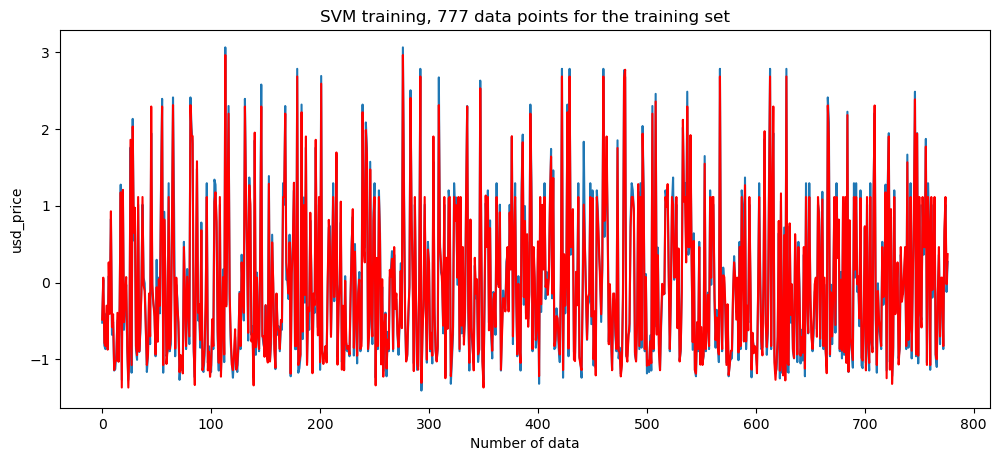

In [9]:
## SVR
#clf= SVR(C=1.0)
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(X_1_train, y_1_train).predict(X_1_train)
#y_rbf = svr_rbf.fit(X, y).predict(X)
# In sample score
In_score = svr_rbf.score(X_1_train, y_1_train)
# Out of sample prediction with test set
y_rbf_test = svr_rbf.fit(X_1_train, y_1_train).predict(X_1_test)

# Plottting the in-sa,ple training set
#axis_x = np.arange(1,subSet_length*.75+1)
axis_x = np.arange(0,rows)

%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})

plt.figure()
plt.plot(axis_x, y_1_train, label= "usd_price")
plt.plot(axis_x, y_rbf,color = 'red', label= "SVM forecast")
plt.title('SVM training, 777 data points for the training set')
plt.xlabel('Number of data')
plt.ylabel('usd_price')
#

'''
pylab.legend()
# legend below figure
pylab.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
In_score_train = svr_rbf.score(X_1_train, y_1_train)
print(In_score_train)
plt.text(0.5,-60.6, r'Score = 0.857' , fontsize=10)
#Plotting Test set regression
axis_x_test = np.arange(1,subSet_length*.25+1)
plt.figure()
plt.plot(axis_x_test, y_1_test, label= "usd_price")
plt.plot(axis_x_test, y_rbf_test, color='red', label= "SVM forecast")
plt.title('SVM Forecast, 125 points test set')
plt.xlabel('Number of data')
plt.ylabel('usd_price')
# legend below figure
pylab.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
# Score returns the coefficient of determination R^2 of the prediction.
In_score_test = svr_rbf.score(X_1_test, y_1_test)
print(In_score_test)
plt.text(0.5,-60.6, r'Score = 0.542' , fontsize=10)
'''
 
## training a linear SVM classifier
#from sklearn.svm import SVC
#svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
#svm_predictions = svm_model_linear.predict(X_test)

############################# END of prediction ###############################

In [10]:
In_score

0.9875688690879414

Inscore training set =  0.9875688690879414
Inscore test set =  0.9890955031335236


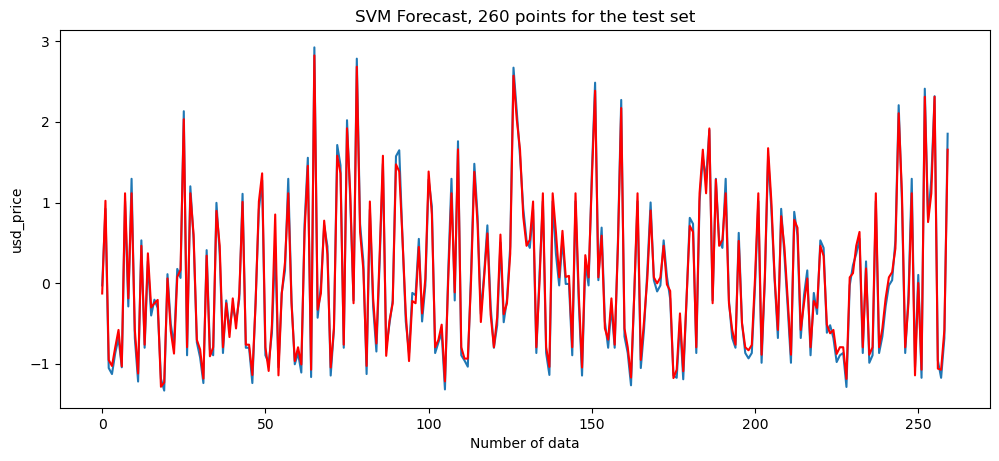

In [20]:
# Plottting the in-sample training set
#axis_x = np.arange(1,subSet_length*.75+1)
axis_x = np.arange(0,rows_test)

y_rbf_test = svr_rbf.fit(X_1_test, y_1_test).predict(X_1_test)
In_score_test = svr_rbf.score(X_1_test, y_1_test)

%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})

plt.figure()
plt.plot(axis_x, y_1_test, label= "usd_price")
plt.plot(axis_x, y_rbf_test,color = 'red', label= "SVM forecast")
plt.title('SVM Forecast, 260 points for the test set')
plt.xlabel('Number of data')
plt.ylabel('usd_price')
#
print('Inscore training set = ' , In_score)
print('Inscore test set = ', In_score_test )

### Conclusions for the SVM Regrression
As you can see due to the careful selection and filtration of the features, Support Vector Machines for regression shows very good results, with high Inscores (similar metric to the $R^2$). So specially for forecasting it will be a must go for this case.
For a general kernel it is difficult to interpret the SVM weights, however for the linear SVM there actually is a useful interpretation: 1) Recall that in linear SVM, the result is a hyperplane that separates the classes as best as possible. The weights represent this hyperplane, by giving you the coordinates of a vector which is orthogonal to the hyperplane. Regarding the importance of each feature there are some interpretations based also in distances of the points to the hyperplanes, but it is a bit oscure, that is why we use another method as well, the Gradient Boosting Tree.

In [12]:
X_1_test.columns[0:10]

Index(['enginesize', 'km_mileage', 'Car_Age', 'cartype_Convertible',
       'cartype_Coupe', 'cartype_Hatchback', 'cartype_Hybrid/Electric',
       'cartype_Luxury', 'cartype_Motorcycle', 'cartype_SUV/Crossover'],
      dtype='object')

### Gradient Boosting Regression
Gradient boosting can be used for regression and classification problems. Here, I will train a model to tackle a the car problem. I will obtain the results from GradientBoostingRegressor with least squares loss and 500 regression trees of depth 4.

n_estimators : the number of boosting stages that will be performed. Later, we will plot deviance against boosting iterations.

max_depth : limits the number of nodes in the tree. The best value depends on the interaction of the input variables.

min_samples_split : the minimum number of samples required to split an internal node.

learning_rate : how much the contribution of each tree will shrink.

loss : loss function to optimize. The least squares function is used in this case however, there are many other options

In [13]:
# Changing training date to arrays
#X_1_a = X_1.as_matrix()
X_1.values.shape
y_1 = y_1.astype(float)
y_1.values
#
# Setting the parameters
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

#### Fit regression model¶
Using gradient boosting regressors and fit it with our training data. Let’s also look and the mean squared error on the test data.

In [14]:
# Converting to a 1D array the 1D vectors
#y_1_train.ravel()

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_1_train, y_1_train.ravel())

mse = mean_squared_error(y_1_test, reg.predict(X_1_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

C:\Users\Jose-Henry\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


The mean squared error (MSE) on test set: 0.1727


#### The mean squared error (MSE) on test set: 0.1724, a very good one.

### Visualize the results. 
#### To do that I will first compute the test set deviance and then plot it against boosting iterations.

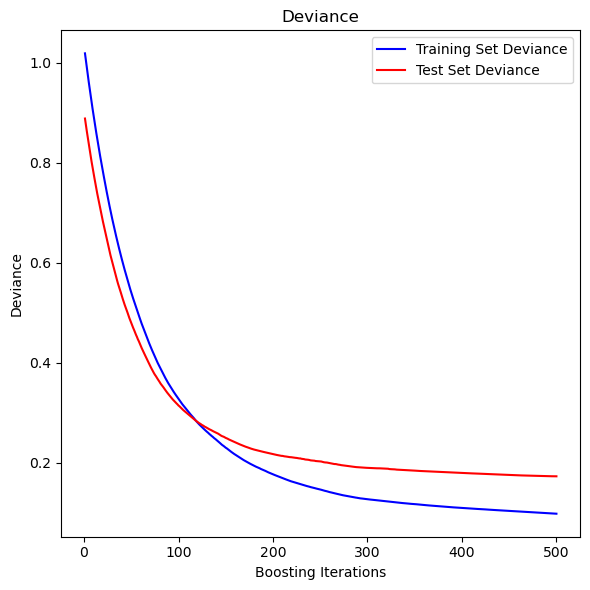

In [15]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_1_pred in enumerate(reg.staged_predict(X_1_test)):
    test_score[i] = reg.loss_(y_1_test, y_1_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

### Feature importance¶
Here I analyze feature importance of the variables affecting the price of the cars in the problem. Impurity-based feature importances methods can be misleading for high cardinality features (many unique values). As an alternative, the permutation importances of reg can be computed on a held out test set.
The permutation_importance function calculates the feature importance of estimators for the dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances.

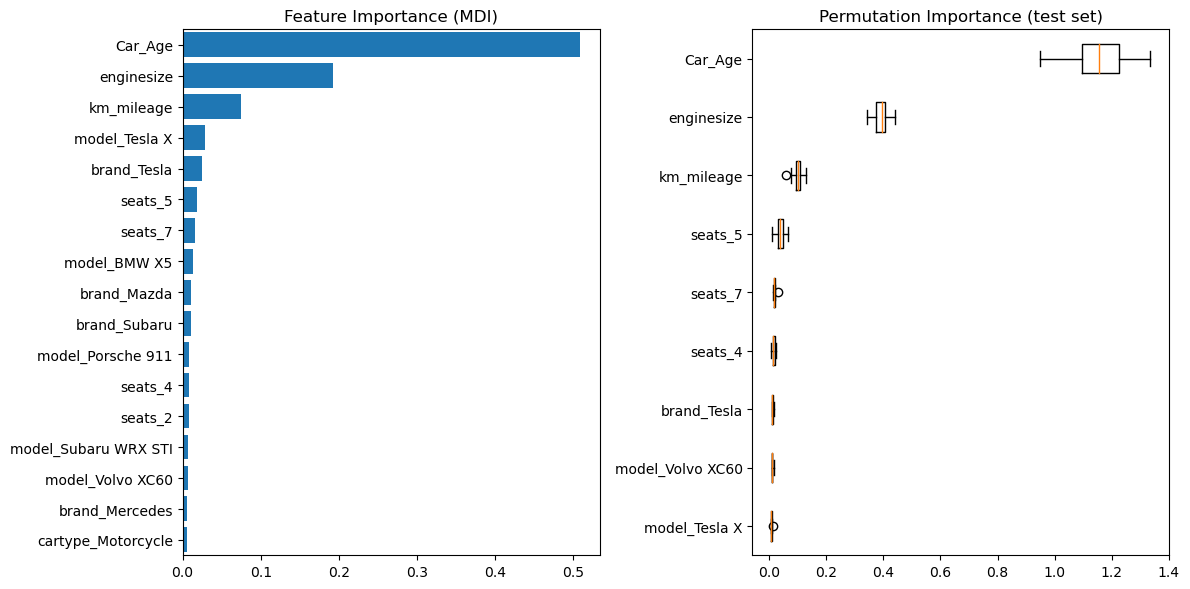

In [17]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos[230:247], np.array(X_1_test.columns)[sorted_idx[230:247]])
plt.title('Feature Importance (MDI)')
## To set the axis to a specific limits
axes = plt.gca()
axes.set_ylim([230,247])


result = permutation_importance(reg, X_1_test, y_1_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx[238:247]].T,
            vert=False, labels=np.array(X_1_test.columns)[sorted_idx[238:247]])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [19]:
print(sorted_idx[238:247])
print(feature_importance[27])
print(np.array(X_1_test.columns)[1])
print(np.array(X_1_test.columns)[0])
print(np.array(X_1_test.columns)[2])
print(sorted_idx.shape)

[ 45 114  22  20  57 210   1   0   2]
0.00045049465537534336
km_mileage
enginesize
Car_Age
(247,)


(230.0, 247.0)

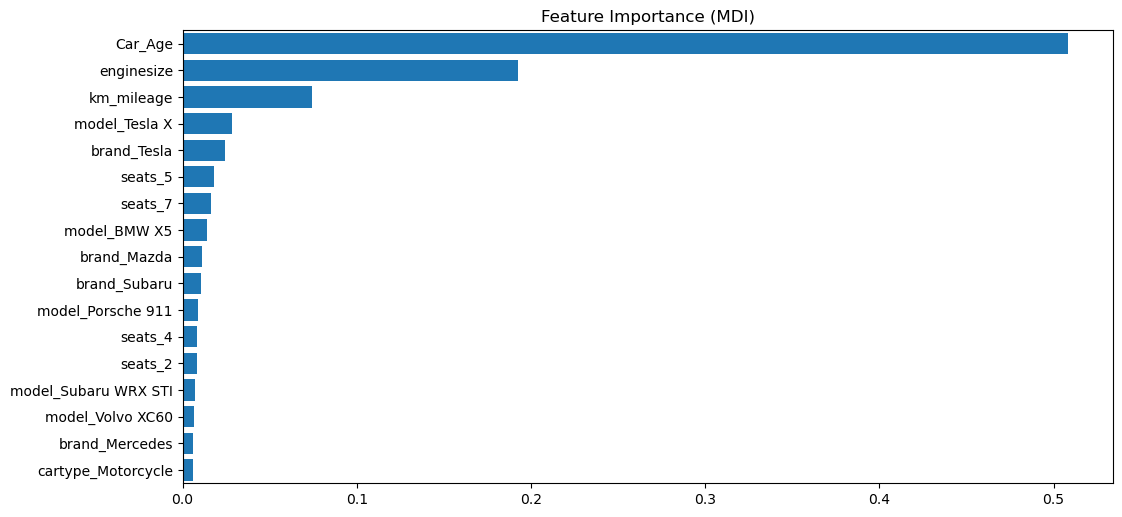

In [18]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos[230:247], np.array(X_1_test.columns)[sorted_idx[230:247]])
plt.title('Feature Importance (MDI)')

axes = plt.gca()
axes.set_ylim([230,247])

### Feature importance
Here we can see what feaures of a car are the most relevant to determine a price. "Car_age" a variable I constructed using the year of frabrication turns out the most relevant variable as expected, the second most important feature is the "engine size", which indirectly summarize different other feautres such as the type of car, big or small. The third important feauture is "km_milage" which tells us also how much util life the car still has. I also show in the graphs above the permutation importance box plot to have a sense of the relative dispersion of each featureand evalute how fitted is our estimator.

### Note: To get the forecasted prices at the right level one needs to inverse the standard scaler